In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [12]:
# import flood hazard layer
shpfile_path = r"C:\Users\akhali20\OneDrive - George Mason University - O365 Production\Phd-Semester 1\GGS 590\Term Project\shapefile\fld_hzd_ar.shp"
fld_hzd_ar = gpd.read_file(shpfile_path)
fld_hzd_ar.columns


Index(['OBJECTID', 'DFIRM_ID', 'VERSION_ID', 'FLD_AR_ID', 'STUDY_TYP',
       'FLD_ZONE', 'ZONE_SUBTY', 'SFHA_TF', 'STATIC_BFE', 'V_DATUM', 'DEPTH',
       'LEN_UNIT', 'VELOCITY', 'VEL_UNIT', 'AR_REVERT', 'AR_SUBTRV',
       'BFE_REVERT', 'DEP_REVERT', 'DUAL_ZONE', 'SOURCE_CIT', 'GFID',
       'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

In [13]:
# Filter the GeoDataFrame where FLD_ZONE is either 'A' or 'AE' for 1% annual chance of flooding
filtered_fld_hzd_ar = fld_hzd_ar[fld_hzd_ar['FLD_ZONE'].isin(['A', 'AE'])]

In [14]:
# Building footprint in DC
DC_build_footprint_path = r"C:\Users\akhali20\OneDrive - George Mason University - O365 Production\Phd-Semester 1\GGS 590\Term Project\shapefile\DC_buildings_footprints.shp"
DC_build_footprint = gpd.read_file(DC_build_footprint_path)
DC_build_footprint.columns

Index(['release', 'capture_da', 'geometry'], dtype='object')

In [15]:
# national structure inventory data
nsi_data_path = r"C:\Users\akhali20\OneDrive - George Mason University - O365 Production\Phd-Semester 1\GGS 590\Term Project\shapefile\nsi_data.shp"
nsi_data = gpd.read_file(nsi_data_path)
nsi_data.columns

Index(['fid', 'fd_id', 'bid', 'cbfips', 'st_damcat', 'occtype', 'bldgtype',
       'num_story', 'sqft', 'found_type', 'found_ht', 'med_yr_blt',
       'val_struct', 'val_cont', 'val_vehic', 'ftprntid', 'ftprntsrc',
       'source', 'students', 'pop2amu65', 'pop2amo65', 'pop2pmu65',
       'pop2pmo65', 'o65disable', 'u65disable', 'x', 'y', 'firmzone',
       'grnd_elv_m', 'ground_elv', 'geometry'],
      dtype='object')

In [16]:
# check the crs of the data
print (DC_build_footprint.crs)
print (filtered_fld_hzd_ar.crs)
print (nsi_data.crs)

EPSG:4326
EPSG:4269
EPSG:4326


In [17]:
# change to similar crs for all the data
filtered_fld_hzd_ar = filtered_fld_hzd_ar.to_crs(epsg=26918)
DC_build_footprint = DC_build_footprint.to_crs(epsg=26918)
nsi_data = nsi_data.to_crs(epsg=26918)

In [18]:
# Intersect the building footprints with the flood hazard layer
intersection = gpd.overlay(DC_build_footprint, filtered_fld_hzd_ar, how='intersection')
# Save the intersection to a new shapefile called 'intersection.shp'
intersection.to_file("intersection.shp")

In [20]:
# Spatial Join with Hazard Layer
nsi_hazard = gpd.sjoin(nsi_data, intersection, how="inner", predicate="intersects")

In [36]:
# check various building types
print(nsi_hazard['bldgtype'].value_counts())

bldgtype
M    172
W     97
S     78
C     24
Name: count, dtype: int64


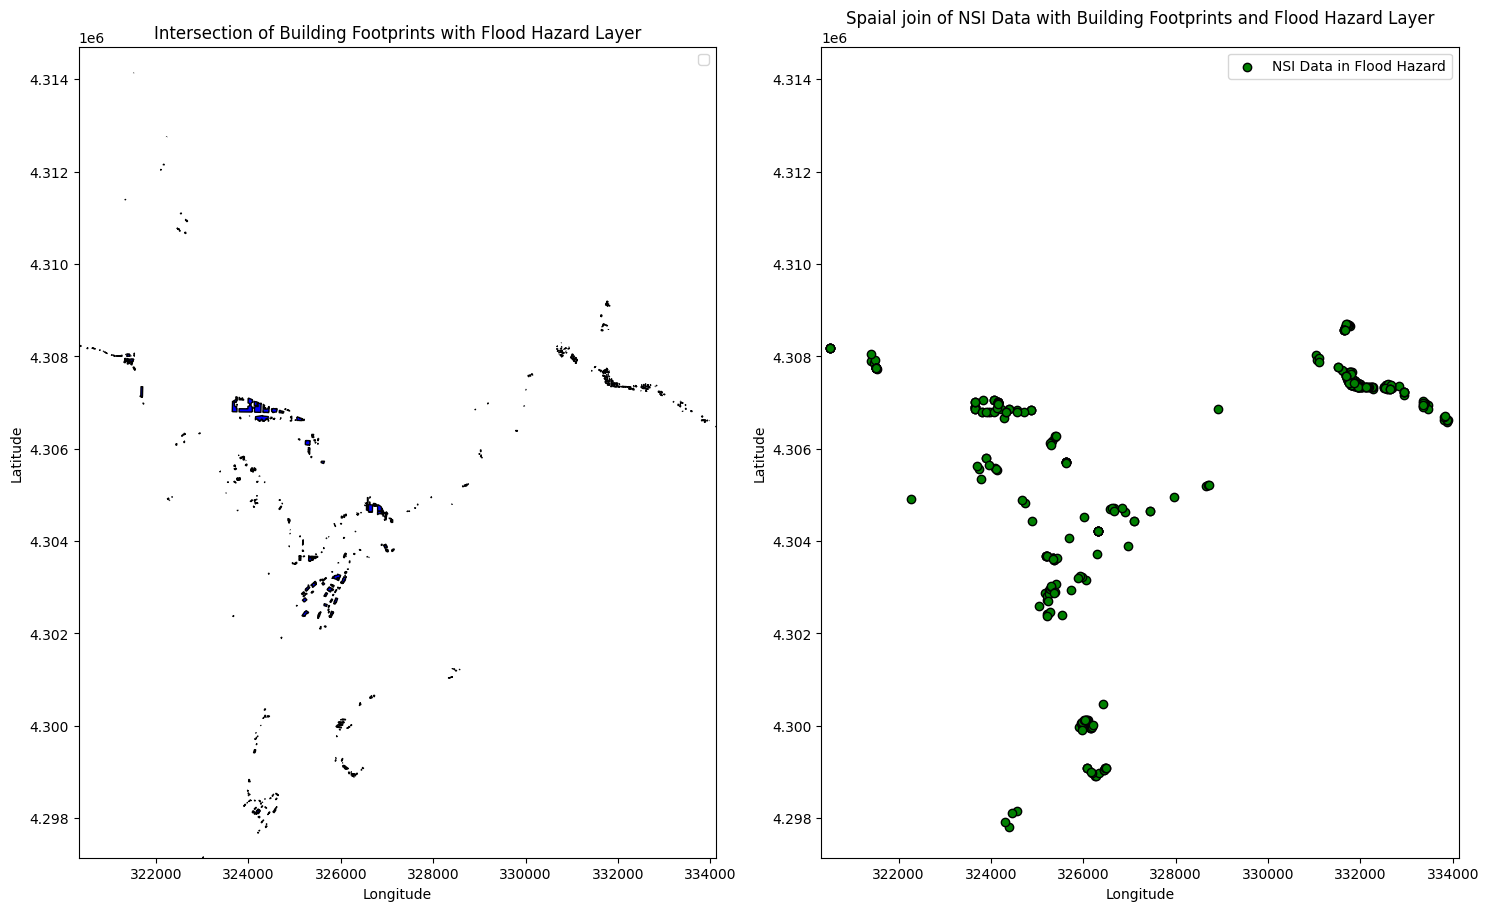

In [24]:
import matplotlib.pyplot as plt

# Plot the intersection of building footprints with the flood hazard layer
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# Define common axis limits
xlim = (intersection.total_bounds[0], intersection.total_bounds[2])
ylim = (intersection.total_bounds[1], intersection.total_bounds[3])

# Plot the first intersection
intersection.plot(ax=ax[0], color='blue', edgecolor='black')
ax[0].set_title('Intersection of Building Footprints with Flood Hazard Layer')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend(['Building Footprints in Flood Hazard'], loc='upper right')
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)

# Plot the second intersection
nsi_hazard.plot(ax=ax[1], color='green', edgecolor='black')
ax[1].set_title('Spaial join of NSI Data with Building Footprints and Flood Hazard Layer')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend(['NSI Data in Flood Hazard'], loc='upper right')
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

plt.tight_layout()
plt.show()

In [37]:
# Structural Vulnerability Analysis
def calculate_svi(row):
    # Assign weights to structural parameters
    material_weight = {"Masonry": 3, "Wood": 1, "Concrete": 4}
    foundation_weight = {"Crawl": 1, "Basement": 3, "Slab": 2}
    foundation_score = foundation_weight.get(row["found_type"], 1)
    material_score = material_weight.get(row["bldgtype"], 2)
    return material_score + foundation_score + row["num_story"]

nsi_hazard["SVI"] = nsi_hazard.apply(calculate_svi, axis=1)


In [26]:
# Economic Vulnerability Analysis
nsi_hazard["EVI"] = nsi_hazard["val_struct"] + nsi_hazard["val_cont"] + nsi_hazard["val_vehic"]

In [ ]:
# Social Vulnerability Analysis
def calculate_soci(row):
    return (0.5 * row["pop2amo65"] + 0.3 * row["u65disable"] + 0.2 * row["students"])

nsi_hazard["SocVI"] = nsi_hazard.apply(calculate_soci, axis=1)


In [34]:
# Composite Vulnerability Index
weights = {"SVI": 0.4, "EVI": 0.4, "SocVI": 0.2}
nsi_hazard["CVI"] = (
    weights["SVI"] * nsi_hazard["SVI"] +
    weights["EVI"] * nsi_hazard["EVI"] +
    weights["SocVI"] * nsi_hazard["SocVI"]
)

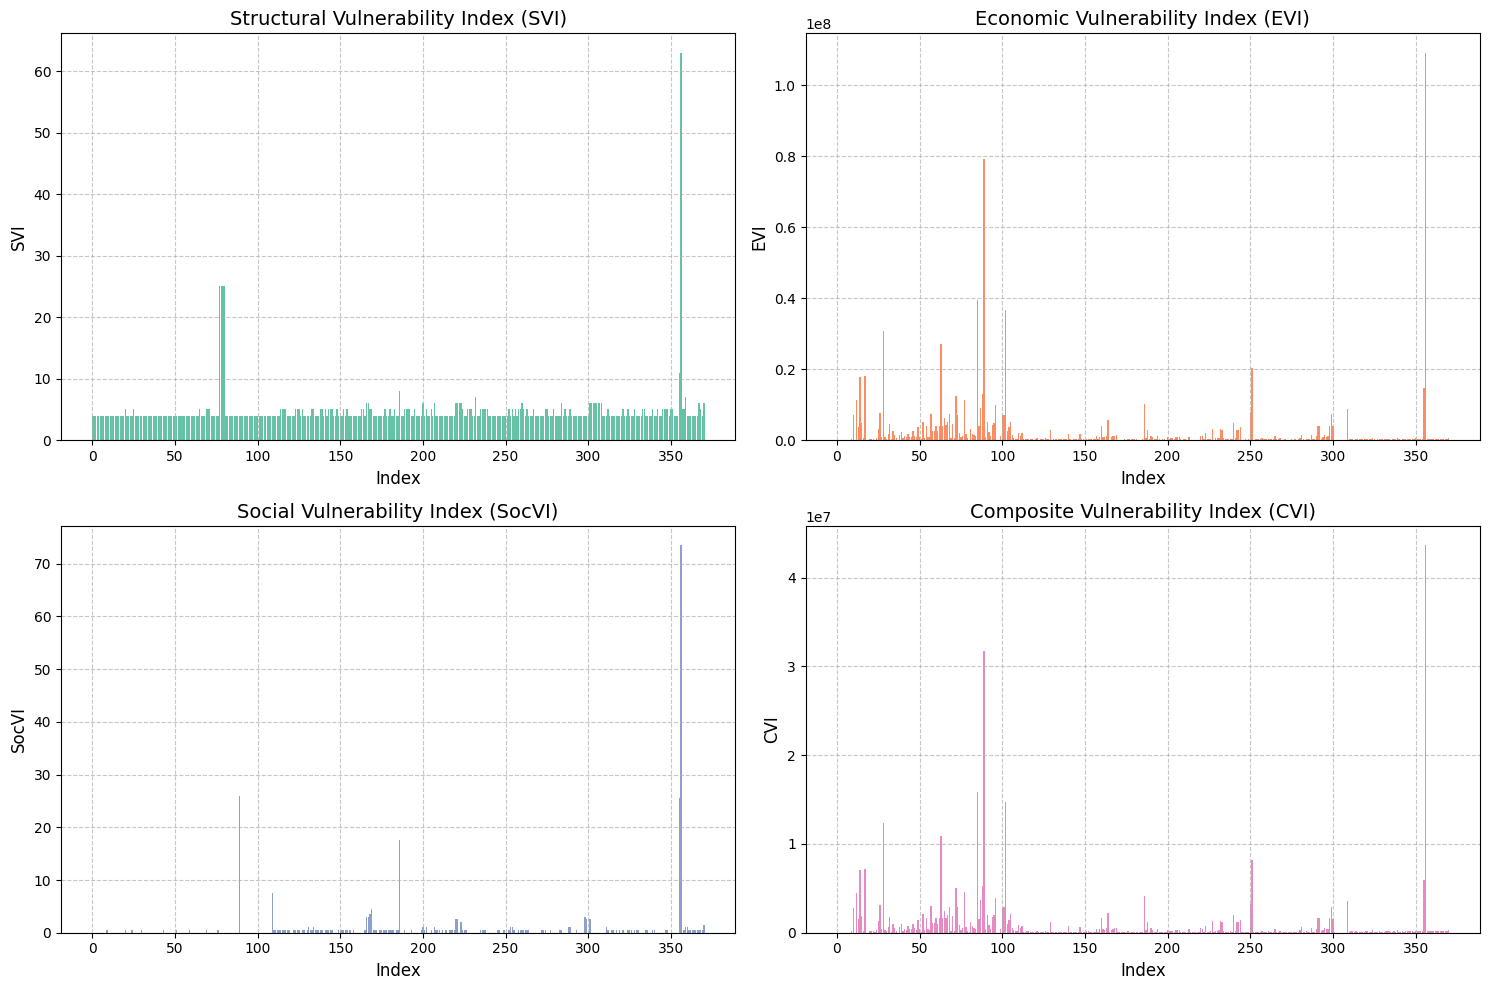

In [ ]:
# Separate bar charts for SVI, EVI, SocVI, and CVI for each building
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot Structural Vulnerability Index (SVI)
axes[0, 0].bar(indices, nsi_hazard['SVI'], color=colors[0])
axes[0, 0].set_title('Structural Vulnerability Index (SVI)', fontsize=14)
axes[0, 0].set_xlabel('Index', fontsize=12)
axes[0, 0].set_ylabel('SVI', fontsize=12)
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# Plot Economic Vulnerability Index (EVI)
axes[0, 1].bar(indices, nsi_hazard['EVI'], color=colors[1])
axes[0, 1].set_title('Economic Vulnerability Index (EVI)', fontsize=14)
axes[0, 1].set_xlabel('Index', fontsize=12)
axes[0, 1].set_ylabel('EVI', fontsize=12)
axes[0, 1].grid(True, linestyle='--', alpha=0.7)

# Plot Social Vulnerability Index (SocVI)
axes[1, 0].bar(indices, nsi_hazard['SocVI'], color=colors[2])
axes[1, 0].set_title('Social Vulnerability Index (SocVI)', fontsize=14)
axes[1, 0].set_xlabel('Index', fontsize=12)
axes[1, 0].set_ylabel('SocVI', fontsize=12)
axes[1, 0].grid(True, linestyle='--', alpha=0.7)

# Plot Composite Vulnerability Index (CVI)
axes[1, 1].bar(indices, nsi_hazard['CVI'], color=colors[3])
axes[1, 1].set_title('Composite Vulnerability Index (CVI)', fontsize=14)
axes[1, 1].set_xlabel('Index', fontsize=12)
axes[1, 1].set_ylabel('CVI', fontsize=12)
axes[1, 1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('vulnerability_indices_separate_barplots.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
# Save to CSV
nsi_hazard[["fd_id", "SVI", "EVI", "SocVI", "CVI"]].to_csv("vulnerability_scores.csv", index=False)

In [38]:
# Display the first few rows of the dataframe to verify the analysis
nsi_hazard[["fd_id", "SVI", "EVI", "SocVI", "CVI"]].describe()

fd_id         SVI           EVI       SocVI           CVI
count  3.710000e+02  371.000000  3.710000e+02  371.000000  3.710000e+02
mean   5.077392e+08    4.749326  2.303360e+06    0.704722  9.213462e+05
std    4.599190e+04    3.776774  8.113899e+06    4.364467  3.245561e+06
min    5.076845e+08    4.000000  0.000000e+00    0.012000  1.602400e+00
25%    5.076882e+08    4.000000  2.267844e+05    0.012000  9.071547e+04
50%    5.077240e+08    4.000000  3.898528e+05    0.012000  1.559428e+05
75%    5.077697e+08    5.000000  1.250959e+06    0.512000  5.003859e+05
max    5.078390e+08   63.000000  1.091512e+08   73.512000  4.366053e+07

C:\Users\akhali20\AppData\Local\Temp\ipykernel_42932\1149466561.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = ax.legend()


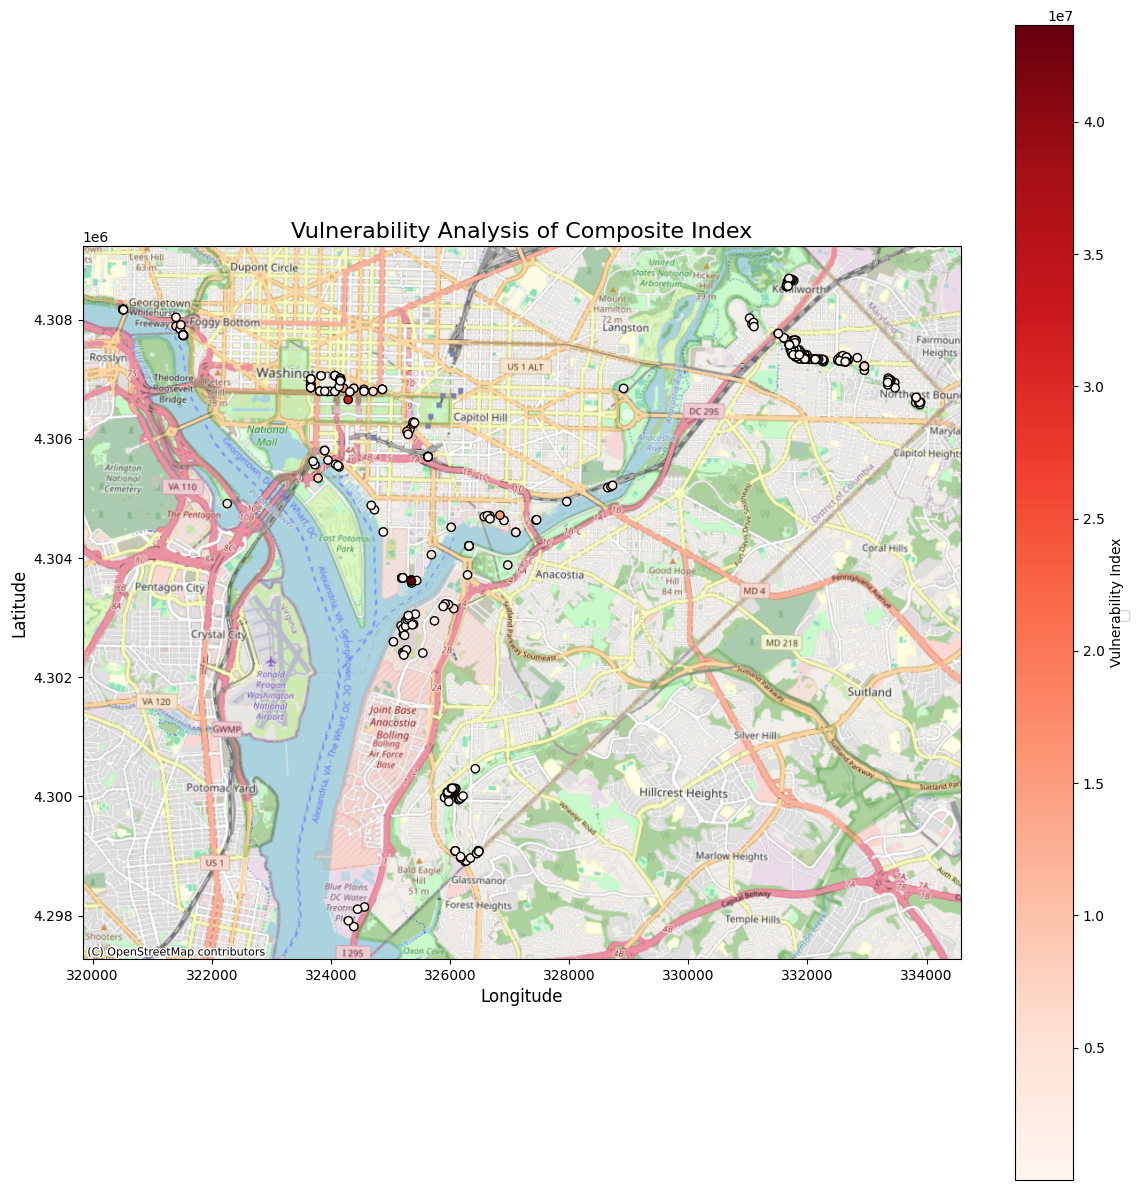

In [55]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

import contextily as ctx  # For adding basemaps

# Plot the vulnerability index on a map
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot the vulnerability index
nsi_hazard.plot(
    column='CVI',
    ax=ax,
    legend=True,
    cmap='Reds',
    edgecolor='black',
    legend_kwds={
        'label': "Vulnerability Index",
        'orientation': "vertical"
    }
)

# Add a basemap
ctx.add_basemap(ax, crs=nsi_hazard.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Add title and labels
ax.set_title('Vulnerability Analysis of Composite Index', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Create the legend explicitly
leg = ax.legend()
leg.set_bbox_to_anchor((1.2, 0.5))  # Move legend outside the plot

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\akhali20\AppData\Local\Temp\ipykernel_42932\897452334.py:21: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1200 with 5 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, cax=cax)


<Figure size 640x480 with 0 Axes>

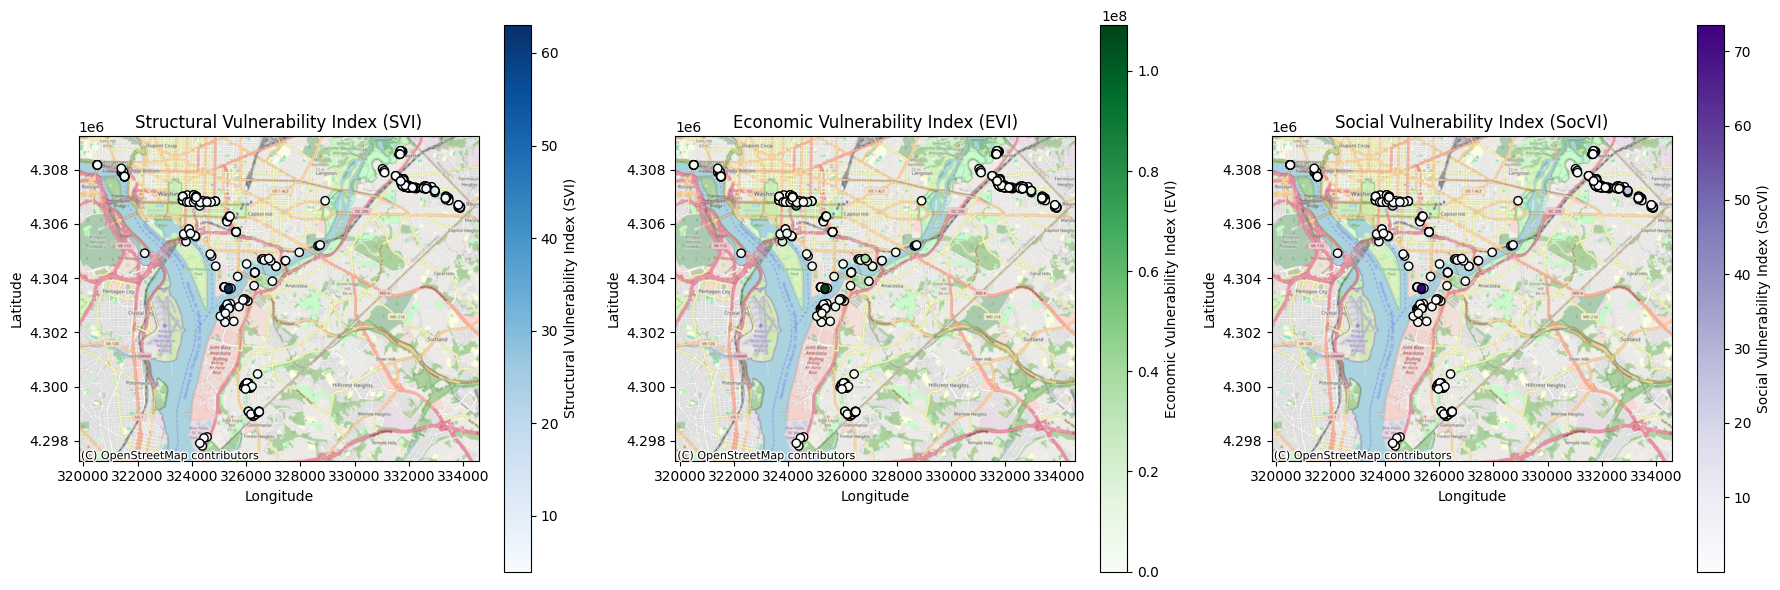

In [53]:
# Create a color map
cmap = plt.cm.Reds

# Normalize the data for the heatmap
norm = plt.Normalize(vmin=nsi_hazard['CVI'].min(), vmax=nsi_hazard['CVI'].max())

# Create a scatter plot with color representing the CVI
sc = ax.scatter(
    nsi_hazard.geometry.x, 
    nsi_hazard.geometry.y, 
    c=nsi_hazard['CVI'], 
    cmap=cmap, 
    norm=norm, 
    alpha=0.6, 
    edgecolor='k'
)

# Create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sc, cax=cax)
cbar.set_label('Composite Vulnerability Index (CVI)', fontsize=12)

# Show the plot
plt.show()
# Plot other vulnerabilities separately
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot Structural Vulnerability Index (SVI)
nsi_hazard.plot(
    column='SVI',
    ax=ax[0],
    legend=True,
    cmap='Blues',
    edgecolor='black',
    legend_kwds={'label': "Structural Vulnerability Index (SVI)", 'orientation': "vertical"}
)
ax[0].set_title('Structural Vulnerability Index (SVI)')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ctx.add_basemap(ax[0], crs=nsi_hazard.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Plot Economic Vulnerability Index (EVI)
nsi_hazard.plot(
    column='EVI',
    ax=ax[1],
    legend=True,
    cmap='Greens',
    edgecolor='black',
    legend_kwds={'label': "Economic Vulnerability Index (EVI)", 'orientation': "vertical"}
)
ax[1].set_title('Economic Vulnerability Index (EVI)')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ctx.add_basemap(ax[1], crs=nsi_hazard.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Plot Social Vulnerability Index (SocVI)
nsi_hazard.plot(
    column='SocVI',
    ax=ax[2],
    legend=True,
    cmap='Purples',
    edgecolor='black',
    legend_kwds={'label': "Social Vulnerability Index (SocVI)", 'orientation': "vertical"}
)
ax[2].set_title('Social Vulnerability Index (SocVI)')
ax[2].set_xlabel('Longitude')
ax[2].set_ylabel('Latitude')
ctx.add_basemap(ax[2], crs=nsi_hazard.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

plt.tight_layout()
plt.show()

C:\Users\akhali20\AppData\Local\Temp\ipykernel_42932\692919984.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = ps.weights.Queen.from_dataframe(nsi_hazard)


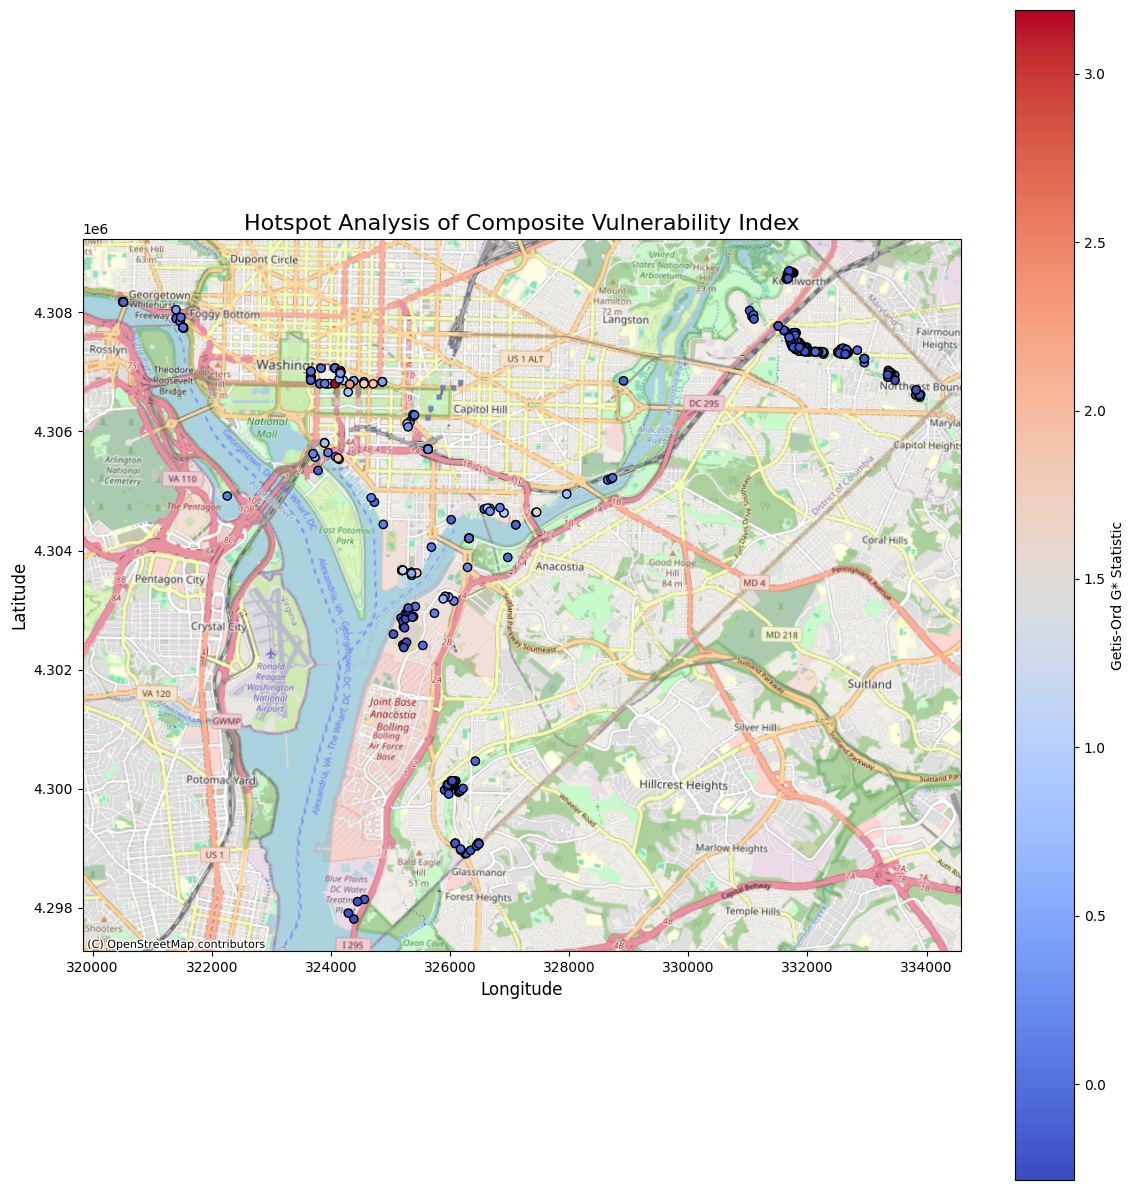

In [68]:
from esda.getisord import G_Local
import libpysal as ps

# Calculate the spatial weights matrix
w = ps.weights.Queen.from_dataframe(nsi_hazard)

# Calculate the Getis-Ord G* statistic
g_star = G_Local(nsi_hazard['CVI'], w)

# Add the G* statistic to the GeoDataFrame
nsi_hazard['G_star'] = g_star.Zs

# Plot the hotspot analysis results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot the G* statistic
nsi_hazard.plot(
    column='G_star',
    ax=ax,
    legend=True,
    cmap='coolwarm',
    edgecolor='black',
    legend_kwds={
        'label': "Getis-Ord G* Statistic",
        'orientation': "vertical"
    }
)

# Add a basemap
ctx.add_basemap(ax, crs=nsi_hazard.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Add title and labels
ax.set_title('Hotspot Analysis of Composite Vulnerability Index', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()



In [69]:
#Function to calculate property loss based on structure content
def calculate_property_loss(row):
    # Example calculation: property loss based on square footage and a fixed rate per square foot
    sqft = row['sqft']
    rate_per_sqft = 506  # On average $506 per square foot
    property_loss = sqft * rate_per_sqft
    return property_loss

# Apply the function to the intersection_1 GeoDataFrame
nsi_hazard['property_loss'] = nsi_hazard.apply(calculate_property_loss, axis=1)

# Display the first few rows of the updated GeoDataFrame
print(nsi_hazard[['bldgtype', 'num_story', 'sqft', 'property_loss']].head())

  bldgtype  num_story      sqft  property_loss
0        S        1.0  16989.00     8596434.00
1        W        1.0   4877.81     2468171.86
2        W        1.0   4488.68     2271272.08
3        S        1.0   5085.37     2573197.22
4        M        1.0  38228.30    19343519.80


C:\Users\akhali20\AppData\Local\Temp\ipykernel_42932\2993626801.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bldgtype', y='property_loss', data=nsi_hazard, palette='viridis')


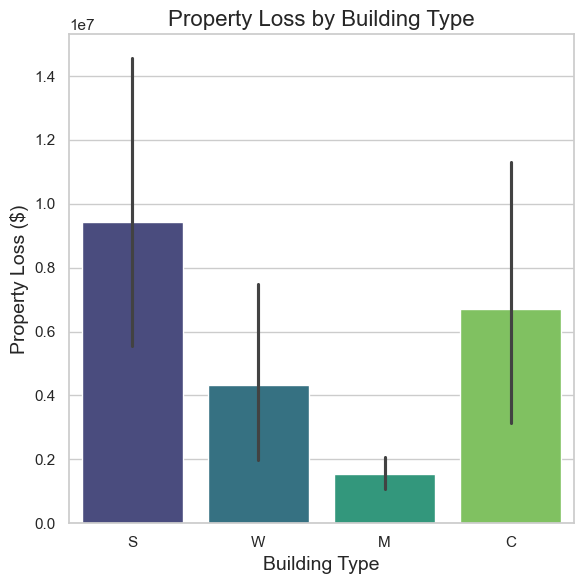

In [75]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a bar plot for property loss by building type
plt.figure(figsize=(6, 6))
sns.barplot(x='bldgtype', y='property_loss', data=nsi_hazard, palette='viridis')

# Set the title and labels
plt.title('Property Loss by Building Type', fontsize=16)
plt.xlabel('Building Type', fontsize=14)
plt.ylabel('Property Loss ($)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

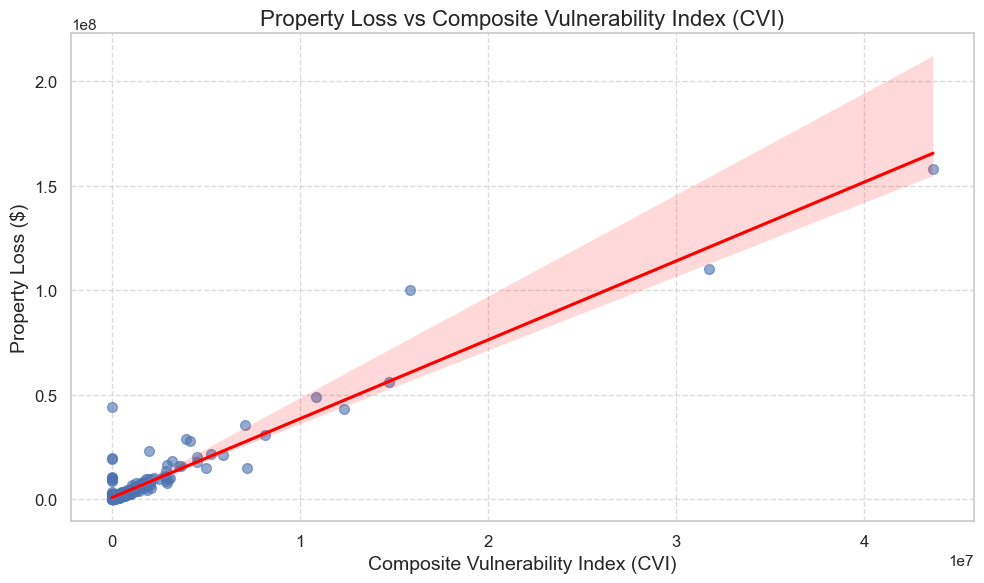

In [76]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='CVI', y='property_loss', data=nsi_hazard, scatter_kws={'s': 50, 'alpha': 0.6}, line_kws={'color': 'red'})

# Set the title and labels
plt.title('Property Loss vs Composite Vulnerability Index (CVI)', fontsize=16)
plt.xlabel('Composite Vulnerability Index (CVI)', fontsize=14)
plt.ylabel('Property Loss ($)', fontsize=14)

# Customize the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('property_loss_vs_cvi.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()